In [1]:
# Import 
import os
import time
import json
import random
import datetime
import numpy as np
import pandas as pd
import ipyvolume as ipv


from IPython.display import display, Image

from pathlib import Path

from tyssue import config
from tyssue import Sheet

from tyssue.io import hdf5, get_sim_dir
from tyssue.io.hdf5 import load_datasets

from tyssue.core.history import History, HistoryHdf5

from tyssue.dynamics import SheetModel as basemodel
from tyssue.dynamics import units, effectors, model_factory

from tyssue.solvers.quasistatic import QSSolver
from tyssue.solvers.viscous import EulerSolver

from tyssue.draw import sheet_view, browse_history
from tyssue.draw import highlight_faces, create_gif
from tyssue.generation import ellipsoid_sheet

from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.sheet import actions, basic_events
#from tyssue.behaviors.sheet.apoptosis_events import apoptosis

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from polarity.dynamics import model, RadialTension
from polarity.dynamics import EllipsoidLameGeometry as geom

from polarity.apoptosis import apoptosis, apoptosis_patterning

from polarity.toolbox import (init,
                              define_fold_position,
                              apoptosis_ventral,
                              apoptosis_lateral,
                              apoptosis_dorsal,
                             )

In [3]:

sim_save_dir = get_sim_dir()/"test_contractility_speed"

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

In [4]:
from polarity.dynamics import RadialTension
model = model_factory(
    [
        RadialTension,
        effectors.LineTension,
        #effectors.FaceContractility,
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
    ])

In [5]:
# Init superegg tissue 
#sheet = init()

abc = [12, 12, 21.0] # Ellipsoid axes

sheet = ellipsoid_sheet(*abc, 13)

for i in range(20):
    geom.scale(sheet, 1/sheet.face_df.area.mean()**0.5, sheet.coords)
    geom.update_all(sheet)


specs = {
    "vert": {
        'radial_tension': 0.0
    },
    "face": {
        'prefered_area': 1.,
        'area_elasticity': 1.,
        "contractility": 0.1,
    },
    "edge": {
        'line_tension': 0.0,
        
    },
    "settings": {
        'lumen_prefered_vol': sheet.settings['lumen_vol'],
        'lumen_vol_elasticity': 1e-3
    }
}

sheet.update_specs(specs, reset=True)

### We first use quasistatic gradient descent to do a first return to equilibrium

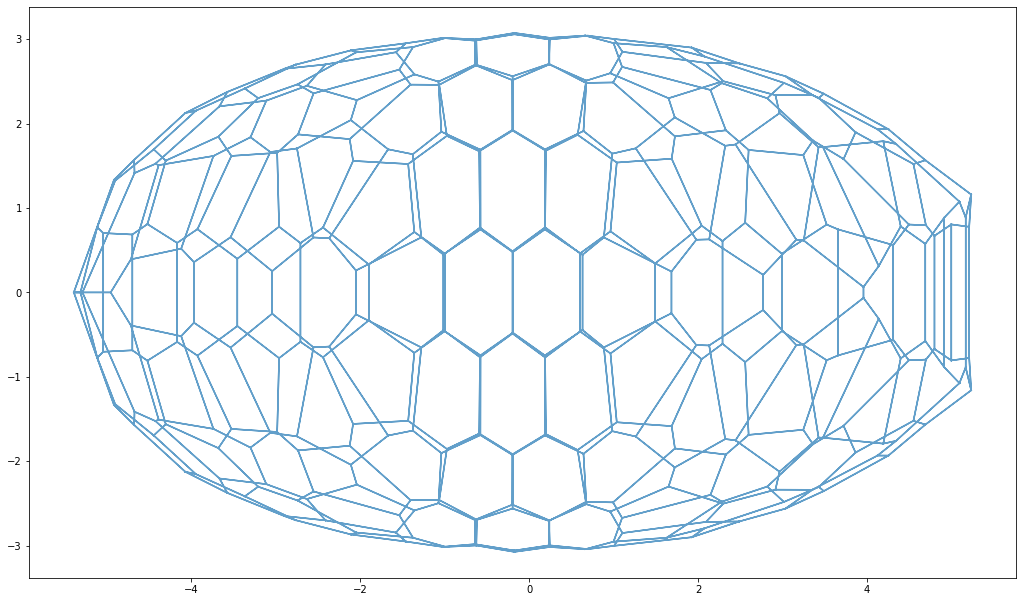

In [6]:
solver = QSSolver(with_t1=False, with_t3=False, with_collisions=False)
res = solver.find_energy_min(sheet, geom, model)
backup_sheet = sheet.copy()

fig, ax = sheet_view(sheet, ['z', 'x'], mode="quick", edge={"alpha":0.7})
fig.set_size_inches(18.5, 10.5, forward=True)

In [7]:
sheet = backup_sheet.copy()

In [8]:
model.labels

['Apical basal tension',
 'Line tension',
 'Area elasticity',
 'Lumen volume elasticity']

In [9]:
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(
    sheet,
    mode="3D",
    coords=['z', 'x', 'y'],
    edge={'color':'white', "visible": True},
    face={'color':'white', 'visible': True}
)
fig



/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

# Init basic information for fold formation

- position of the fold
- define 3 "categories" of apoptotic cells

In [10]:
define_fold_position(sheet, fold_number = 1, position=[-0.6, 0.6])
print(len(sheet.face_df[sheet.face_df.fold==1]))

ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.fold,
                        'colormap':'Reds',
                        'visible':True})
fig


22


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [11]:
sheet.face_df['apoptosis'] = 0
apoptosis_ventral(sheet, 1)
apoptosis_lateral(sheet, 1)
apoptosis_dorsal(sheet, 1)

ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.apoptosis,
                        'colormap':'Reds',
                        'visible':True})
fig

print(len(sheet.face_df[sheet.face_df.fold>0]))
print(len(sheet.face_df[sheet.face_df.apoptosis>0]))
print(len(sheet.face_df[sheet.face_df.apoptosis==1]))
print(len(sheet.face_df[sheet.face_df.apoptosis==2]))
print(len(sheet.face_df[sheet.face_df.apoptosis==3]))


22
4
2
2
0


In [12]:
backupSheet2 = sheet.copy()

# Starting the viscous solver

In [13]:
default_pattern=    {
        "t":0,
        "dt":0.1
    }
def apoptosis_patterning(sheet, manager, **kwargs):
    """Apoptosis process patterning, which put cell in apoptosis progressively.


    """
    specs = default_pattern
    specs.update(**kwargs)
    # variable a passer en parametre?
    t = specs['t']
    
    #phi_min = -t*max(np.abs(sheet.face_df.phi))/120+max(np.abs(sheet.face_df.phi))
    phi_min = -t*max(np.abs(sheet.face_df.phi))/12+max(np.abs(sheet.face_df.phi))

    l_index_apoptosis_cell = sheet.face_df[(np.abs(sheet.face_df.phi)>phi_min) 
                                           & (sheet.face_df.apoptosis>0)
                                          ].index.values
    apopto_kwargs = sheet.settings['apoptosis'].copy()
    for c in l_index_apoptosis_cell:
        apopto_kwargs.update(
        {
            'face_id': c,
        }
        )
        manager.append(apoptosis, **apopto_kwargs)

    
    specs.update({"t" : specs['t']+specs['dt']})
    manager.append(apoptosis_patterning, **specs)


In [14]:
def run_sim(sim_save_dir, sheet, constriction, radial_tension, iteration=0):
    
    hf5file = '{}_constriction_{}_radialtension.hf5'.format(
        constriction, radial_tension)
    hf5file = os.path.join(sim_save_dir, hf5file)
    
    print('starting {}'.format(hf5file))
    try:
        os.mkdir(sim_save_dir)
    except IOError:
        pass
    
    apoptosis_settings = {
        "critical_area": 0.5,
        "contract_rate": constriction,
        "basal_contract_rate": 1.01,
        "shrink_span": 2,
        "radial_tension": radial_tension,
        "max_traction":10,
        "current_traction":0,
        "geom": geom,
    }

    # Add some information to the sheet and copy initial sheet
    sheet2 = sheet.copy(deep_copy=True)
    sheet2.face_df['id'] = sheet2.face_df.index.values
    sheet2.settings['apoptosis'] = apoptosis_settings
    

    #sheet2 = apoptosis_process(dirname, solver, sheet2)
    
    # Time property
    dt = 0.1       # time step
    rf = 1.        #record frequency
    tf = 60           #final time solving
    
    # Initiate manager
    manager = EventManager('face')
    #manager.append(basic_events.reconnect)
    
    #Initiate history to save all columns in all df
    history = HistoryHdf5(
        sheet2, 
        save_every=rf,
        dt=dt, 
        extra_cols={
            "face": list(sheet2.face_df.columns),
            "edge": list(sheet2.edge_df.columns),
            "vert": list(sheet2.vert_df.columns)
            }, 
        hf5file=hf5file)
    print(sheet2.vert_df.columns)
    # Starting viscous solver
    solver = EulerSolver(
        sheet2,
        geom, 
        model,
        history=history,
        manager=manager,
        bounds=(
            -sheet2.edge_df.length.median()/10,
            sheet2.edge_df.length.median()/10
        )
    )

    manager.update()
    sheet2.vert_df['viscosity'] = 0.1
    
    
    # Solving part... 
    sheet2.settings["dt"] = dt
    
    manager.append(apoptosis_patterning)
    manager.update()
    
    
    # Fold process ~ 3H
    # Apoptotic process ~ 30min
    # -> apical constriction ~20min
    # -> force apico basal ~ 10min
    solver.solve(tf, dt)
    #save_sheet(solver.history, path=dirname, start_number=0, dt=dt)
    
    print(solver.history.time_stamps.shape)
    print('{} done'.format(hf5file))
    print('~~~~~~~~~~~~~~~~~~~~~\n')
    
    #libère la mémoire ? 
    #del solver
    
    return sheet2, solver

In [15]:
sheet2, solver = run_sim(sim_save_dir, sheet, 1.005, 0.1)

starting /data/Simulations/test_contractility_speed/1.005_constriction_0.1_radialtension.hf5
Index(['x', 'y', 'z', 'is_active', 'rho', 'height', 'basal_shift', 'srce_o',
       'theta', 'vitelline_rho', 'delta_rho', 'radial_tension'],
      dtype='object')


/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/tyssue-0.5.0-py3.7-linux-x86_64.egg/tyssue/core/history.py:254: UserWarning: The file already exist and the new filename is /data/Simulations/test_contractility_speed/1.005_constriction_0.1_radialtension4.hf5
  new_hf5file
/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/tyssue-0.5.0-py3.7-linux-x86_64.egg/tyssue/behaviors/sheet/actions.py:297: UserWarning: deprecated, use increase function
  warnings.warn("deprecated, use increase function")


(61,)
/data/Simulations/test_contractility_speed/1.005_constriction_0.1_radialtension.hf5 done
~~~~~~~~~~~~~~~~~~~~~



In [17]:
solver.history.hf5file

PosixPath('/data/Simulations/test_contractility_speed/1.005_constriction_0.1_radialtension2.hf5')

In [20]:
specs = {
    "face": {
        "visible": True,
        "color": lambda sheet : sheet.face_df['apoptosis'],
        "colormap": 'viridis',
    },
    "edge": {
        "color": 'k'
    }
}


browse_history(solver.history, coords=['z', 'x', 'y'], **specs)

interactive(children=(IntSlider(value=0, description='i', max=60), Output()), _dom_classes=('widget-interact',…